In [1]:
import pickle, copy, json, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps
from random import shuffle
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import la_forge.utils as lf_utils
#lf_utils.set_publication_params()
fig_dir = '/home/baierj/projects/hasasia2/hasasia2_paper/figures'
os.chdir('/home/baierj/projects/hasasia2/pta_sensitivity_tuning/')

In [2]:
my_cmap = sns.light_palette("seagreen", as_cmap=False, n_colors=15)

In [3]:
my_cmap

[(0.921460863132993, 0.9512120106378944, 0.9302557793948234),
 (0.8691501309256814, 0.922545142066915, 0.8886737105378878),
 (0.8168393987183697, 0.8938782734959356, 0.8470916416809522),
 (0.7645286665110582, 0.8652114049249562, 0.8055095728240165),
 (0.7093117825144515, 0.834951932544478, 0.7616173890305844),
 (0.6570010503071398, 0.8062850639734985, 0.7200353201736488),
 (0.6046903180998282, 0.7776181954025192, 0.6784532513167132),
 (0.5494734341032215, 0.7473587230220409, 0.6345610675232811),
 (0.49716270189590994, 0.7186918544510615, 0.5929789986663455),
 (0.44485196968859836, 0.6900249858800821, 0.5513969298094099),
 (0.39254123748128666, 0.6613581173091027, 0.5098148609524742),
 (0.33732435348468004, 0.6310986449286244, 0.46592267715904223),
 (0.2850136212773684, 0.602431776357645, 0.4243406083021066),
 (0.23270288907005676, 0.5737649077866656, 0.3827585394451709),
 (0.1803921568627451, 0.5450980392156862, 0.3411764705882353)]

In [4]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as utils
import hasasia.skymap as hsky

In [5]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

# PTA Specs
|PTA| Npsr | Tspan [yr] | (whitened) rms [ $\mu$ s] | ave. irn |
|:---:|:---:|:---:|:-------:|:----:| 
|NG|68|16| ~ 0.9 | ? |
|PPTA | 32 | 18  | ~2.7 | ? |
|EPTA | 25 | 24.5 | ~2.6 | ? |
|InPTA | 14 | 3.5 | ~8.1 | ? |
|MPTA | 78 | 2.5 | ~1.1 | ? |

referencing timing papers: [NANOGrav](https://arxiv.org/pdf/2306.16217.pdf), [EPTA](https://arxiv.org/pdf/2306.16224.pdf), [PPTA](https://arxiv.org/pdf/2306.16224.pdf), [InPTA](https://arxiv.org/pdf/2206.09289.pdf), [MPTA](https://arxiv.org/pdf/2212.04648.pdf)

# The Generic PTA (GPTA)

- We create a PTA with ${Npsr}$ pulsars, which have been timed for up to $16$ years to simulate a realistic pulsar timing array. 
- We craft this pta with an white noise rms similar to that of NG15. 
- We inject red noise from a 2d distribution of red noise parameters, which were significant in NG15.
- For sky locations, we construct an emprical distribution based off of the approx locations of pulsars in the international pulsar timing array data release 3.

In [5]:
os.getcwd()

'/home/baierj/projects/hasasia2/pta_sensitivity_tuning'

In [6]:
Npsr=115
# set random seed so you don't have to keep tuning it
np.random.seed(0)
with open('../data/tspans.json', 'r') as fp:
    tspans = json.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../data/tspans.json'

In [7]:
ipta_dr2_noise=np.genfromtxt('./data/ipta_dr2_rms.txt', delimiter='\t', skip_header=1,
                                   dtype='U20, f4, f4, f4, f4',
                                   names=['psr','theta', 'phi','wn','tspan'])

In [8]:
ipta_dr3_psrs=np.genfromtxt('./data/dr3_psrs.txt', delimiter=' ', skip_header=1,
                                   dtype='U20, f4, f4, f4, f4, U20, U20, U20, U20, U20, U20',
                                   names=['psr','period', 'DM','P_b','R', 'EPTA', 'InPTA', 'NANOGrav', 'PPTA', 'MPTA', 'LOFAR'])

In [9]:
NG_wn =np.genfromtxt('./data/NG15_noise.txt', delimiter=' ', skip_header=1,
                                    dtype='U20, U20, U20, U20, U20, U20, U20, U20, f4, f4, f4, f4, U20, U20',
                                    names=['psr','ntoas', '-','-','-', '-', '-', '-', "full_rms", "white_rms", "A_rn", "gamma_rn", "bf" "fig_num"])
# NG_wn=np.genfromtxt('./data/NG15_white_noise.txt', delimiter=' ', skip_header=1,
#                                    #dtype='U20, f4, f4, f4, f4, U20, U20, U20, U20, U20, U20',
#                                     names=["white_rms", "A_rn", "gamma_rn"])
NG_rn=np.genfromtxt('./data/NG15_rn.txt', delimiter=' ', skip_header=1,
                                   #dtype='U20, f4, f4, f4, f4, U20, U20, U20, U20, U20, U20',
                                    names=["A_rn", "gamma_rn"])

In [10]:
# this mess combines the whitened rms and the full rms of the NG data
# we want to use whitened rms if it exists, otherwise use full rms
NG15_wn = []#NG_wn['white_rms']
for i in range(len(NG_wn)):
    #print(i)
    if NG_wn['white_rms'][i] == NG_wn['white_rms'][i]: # i dont know why this line of code does what i want, but it does
        NG15_wn.append(NG_wn['white_rms'][i])
    else:
        NG15_wn.append(NG_wn['full_rms'][i])
print("full :", NG_wn['full_rms'][:5])
print("whitened: ", NG_wn['white_rms'][:5])
print("combo: ", NG15_wn[:5])

full : [0.326 0.32  0.856 0.794 0.597]
whitened:  [  nan   nan 0.251 0.263   nan]
combo:  [0.326, 0.32, 0.251, 0.263, 0.597]


In [11]:
dr3_ra = []
dr3_dec = []
#from astropy.coordinates import Angle as ang
for psr in ipta_dr3_psrs['psr']:
    #print(psr)
    dr3_ra.append(int(psr[1:3])*15+int(psr[3:5])*15/60)#+np.random.uniform(0,60)*15/3600)
    #boolean mask to get the sign of the declination
    sgn = int((psr[5]=='+')*2 - 1)
    dr3_dec.append(sgn*(int(psr[6:8])+int(psr[8:10])*1/60))#+np.random.uniform(0,60)*1/3600)
    

In [12]:
theta_ipta =  [np.pi/2- np.deg2rad(dr3_dec[i]) for i in range(len(dr3_dec))]
phi_ipta = [np.deg2rad(dr3_ra[i]) for i in range(len(dr3_ra))]
# phi ipta should be in [0, 6.28] radians as it is the azimuthal angle
# theta ipta should be in [0, 3.14] radians as it is the polar angle
# make empirical distribution of sky locations
phi_hist = np.histogram(phi_ipta, bins=10, density=True)
phi_rv = sps.rv_histogram(phi_hist)
theta_hist = np.histogram(theta_ipta, bins=10, density=True)
theta_rv = sps.rv_histogram(theta_hist)
# Get Npsrs from this sky distribution for our GPTA
theta_gpta = theta_rv.rvs(size=Npsr)
phi_gpta = phi_rv.rvs(size=Npsr)

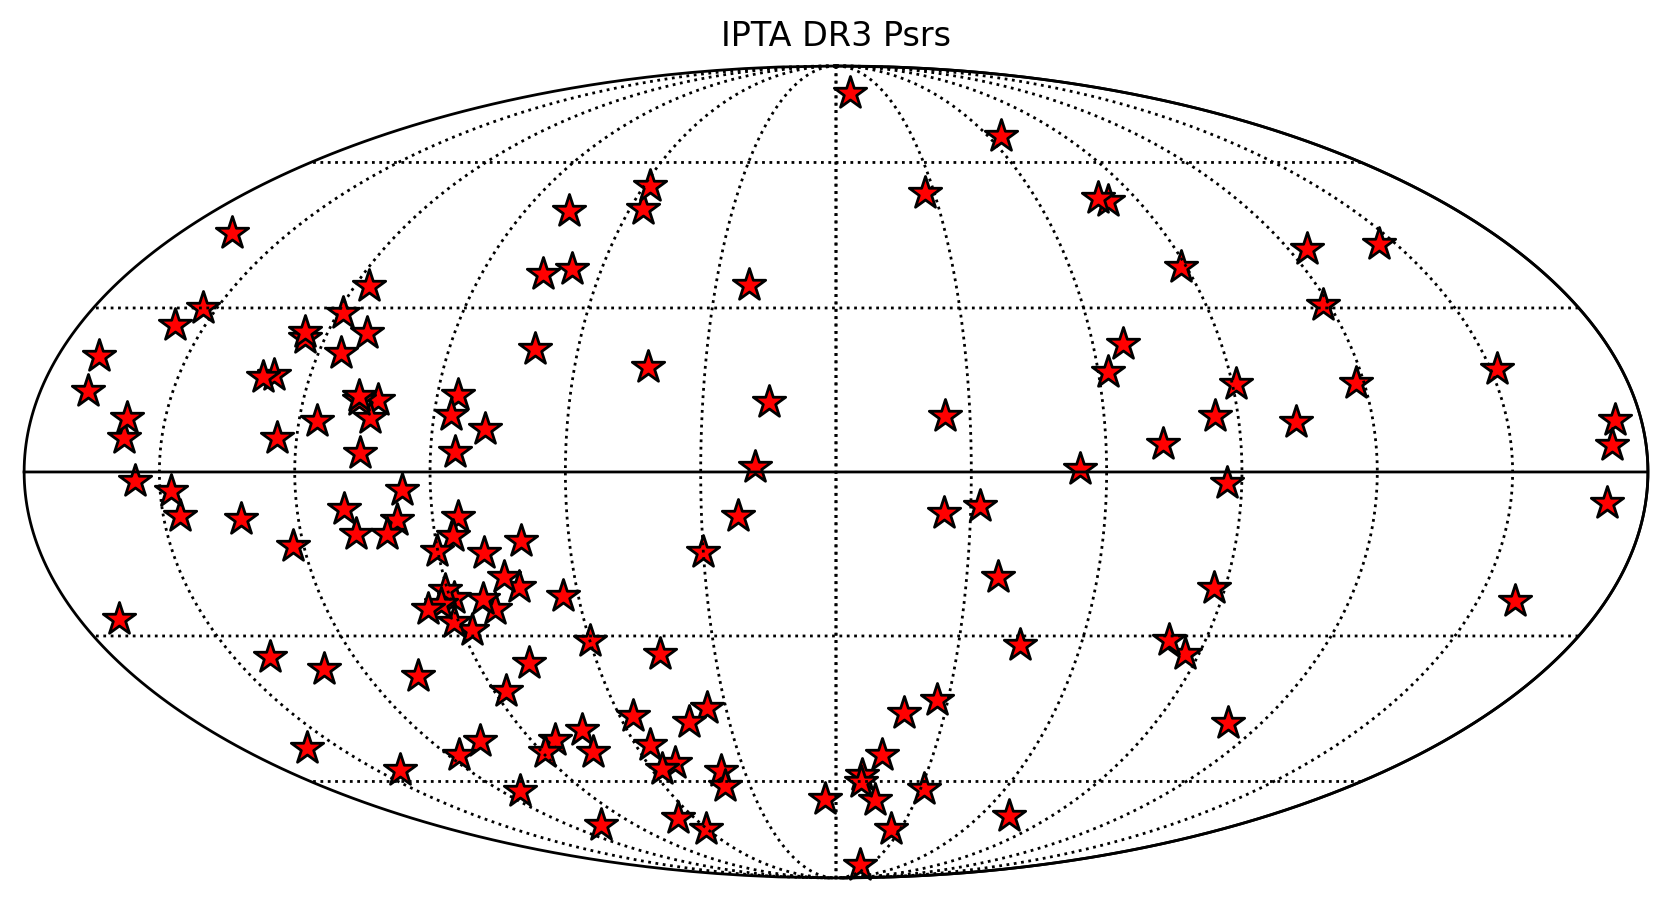

In [13]:
hp.mollview(rot = (180,0,0),
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(theta_ipta,phi_ipta,marker='*',
                        color='red',edgecolors='k',s=150,)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.title('IPTA DR3 Psrs')
plt.show()
plt.close()

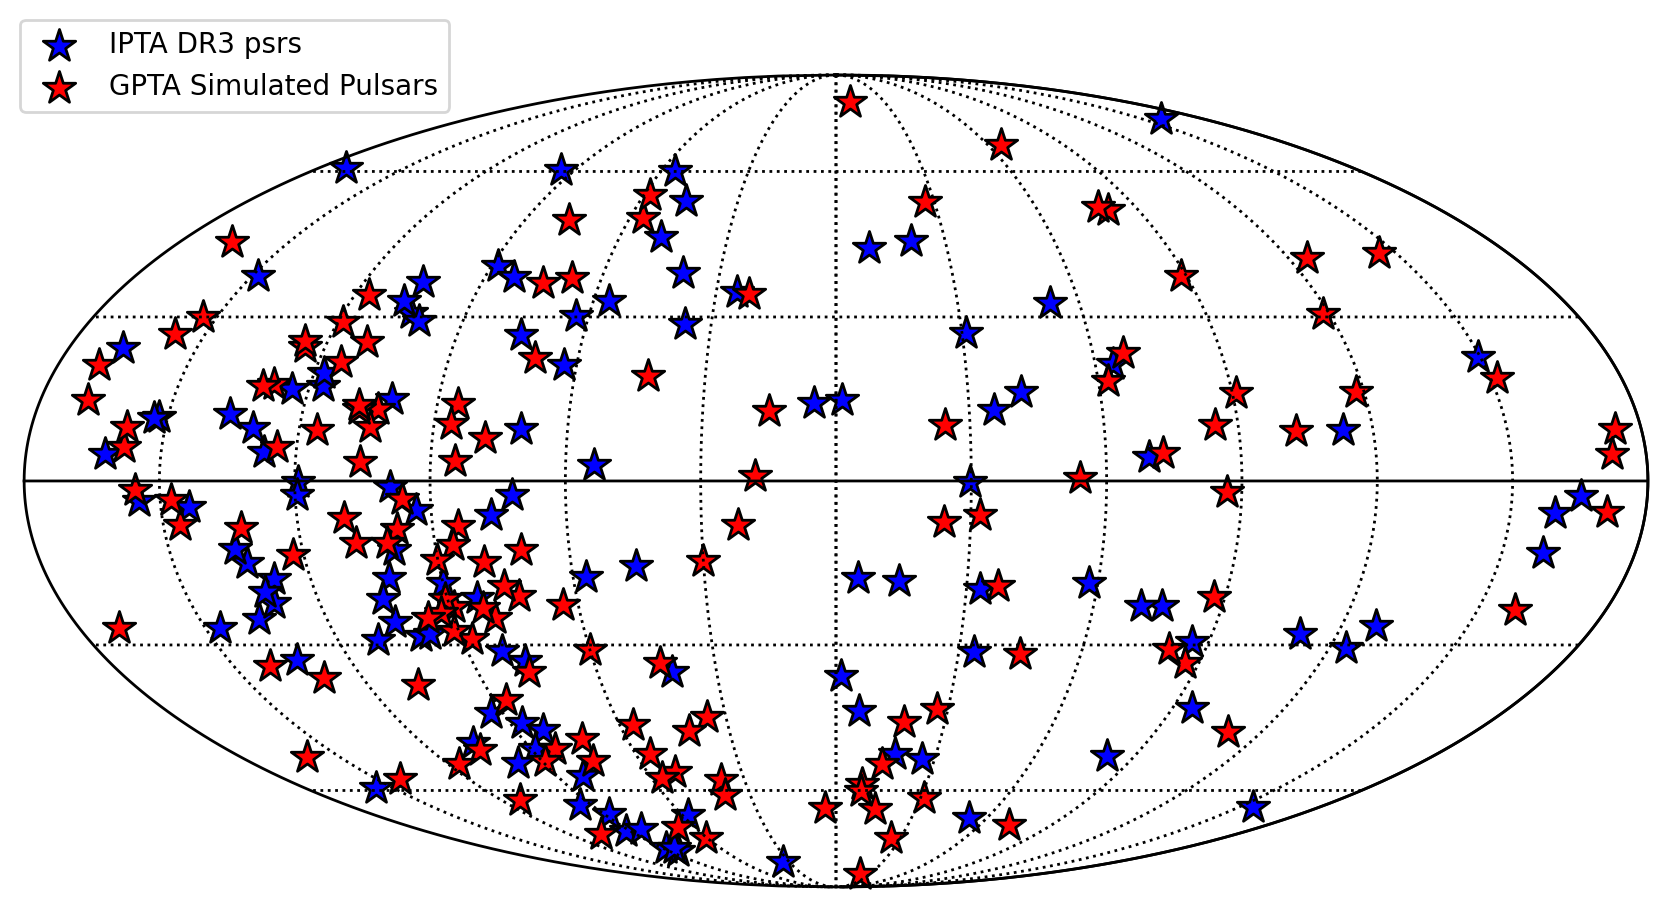

In [14]:
hp.mollview(rot = (180,0,0),
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(theta_gpta,phi_gpta,marker='*',
                        color='blue',edgecolors='k',s=150,)
hp.visufunc.projscatter(theta_ipta,phi_ipta,marker='*',
                        color='red',edgecolors='k',s=150,)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
#plt.title('GPTA Pulsars')
plt.legend(['IPTA DR3 psrs', "GPTA Simulated Pulsars"], loc=(0., 0.95))
#plt.savefig(f'{fig_dir}/gpta_sky_locs.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

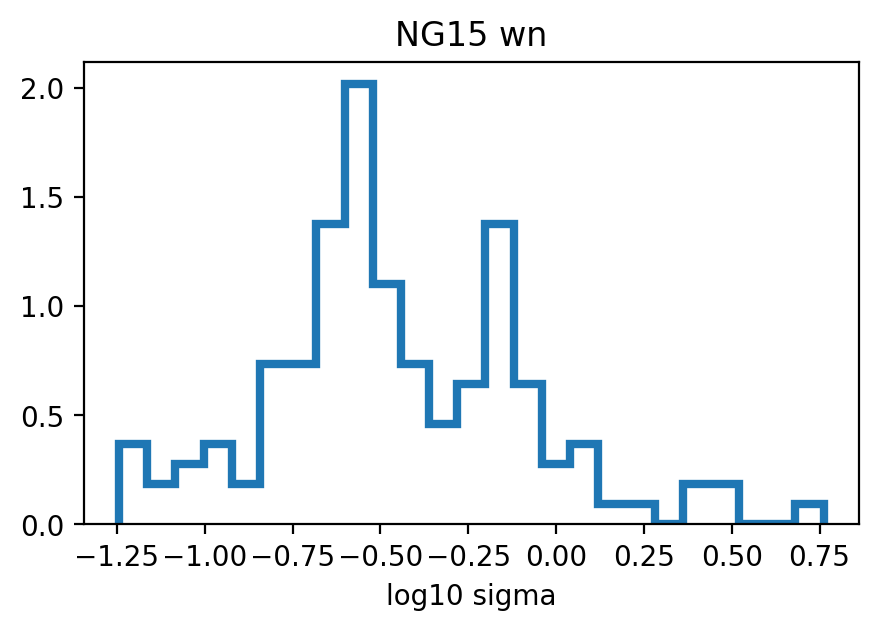

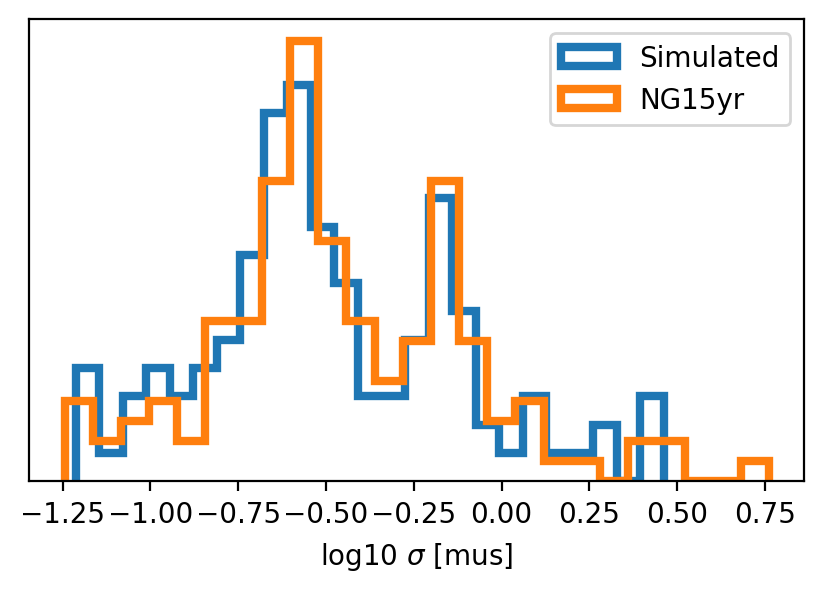

In [15]:
# make empirical distribution of the white noise
# use log spacing to ensure faithful reconstruction of outlier low wn psrs (these are important)
NG15_wn_hist = np.histogram(np.log10(NG15_wn), bins=25, density=True)
plt.figure(figsize=[5,3])
plt.hist(np.log10(NG15_wn), bins=25, density=True, histtype='step', linewidth=3)
plt.xlabel("log10 sigma")
plt.title("NG15 wn")
plt.show()
plt.close()
NG15_wn_rv = sps.rv_histogram(NG15_wn_hist)
# draw from distribution
# undo the logging here
sigmas = 10**(NG15_wn_rv.rvs(size=Npsr))
# plot distribution
plt.figure(figsize=[5,3])
plt.hist(np.log10(sigmas), histtype='step', density=True, linewidth=3, bins=25, label = "Simulated")
plt.hist(np.log10(NG15_wn), bins=25, density=True, histtype='step', linewidth=3, label="NG15yr")
plt.legend()
plt.xlabel("log10 $\sigma$ [mus]")
plt.yticks([])
#plt.title("White Noise")
plt.show()
sigmas*=10**-6

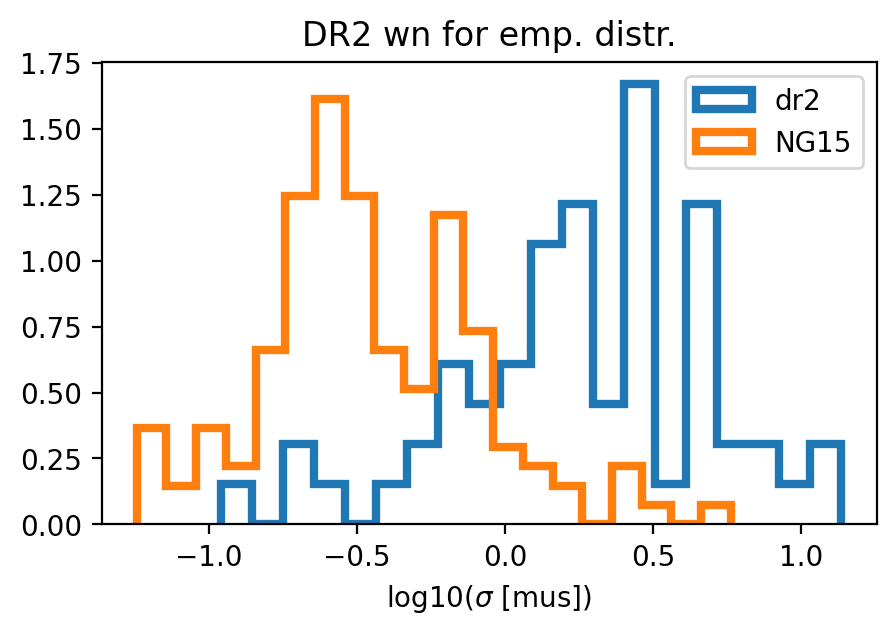

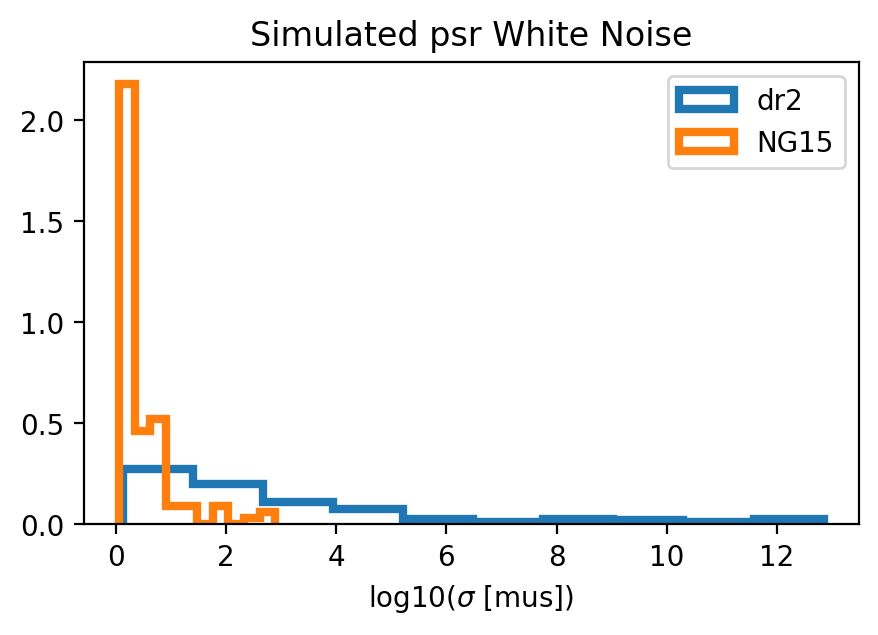

In [16]:
# make empirical distribution of the white noise
dr2_wn = np.histogram(np.log10(ipta_dr2_noise['wn']), bins=20, density=True)
plt.figure(figsize=[5,3])
plt.hist(np.log10(ipta_dr2_noise['wn']), bins=20, density=True, histtype='step', linewidth=3, label='dr2')
plt.hist(np.log10(NG15_wn), bins=20, density=True, histtype='step', linewidth=3, label='NG15')
plt.xlabel("log10($\sigma$ [mus])")
plt.title("DR2 wn for emp. distr.")
plt.legend()
plt.show()
plt.close()
dr2_wn_rv = sps.rv_histogram(dr2_wn)
# draw from distribution
old_sigmas = 10**(dr2_wn_rv.rvs(size=Npsr))
# plot distribution
plt.figure(figsize=[5,3])
plt.hist(old_sigmas, histtype='step', density=True, linewidth=3, label='dr2')
plt.hist(sigmas/10**-6, histtype='step', density=True, linewidth=3, label='NG15')
plt.xlabel("log10($\sigma$ [mus])")
plt.title("Simulated psr White Noise")
plt.legend()
plt.show()
old_sigmas*=10**-6

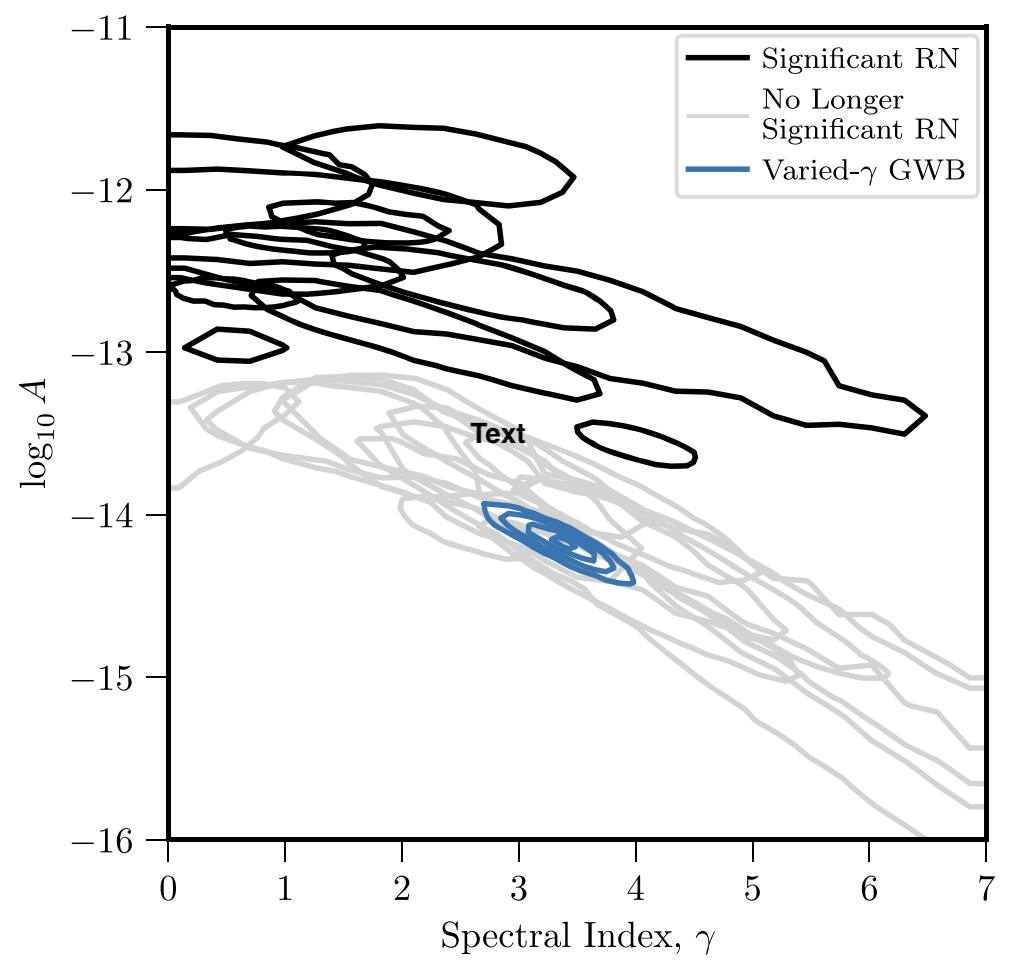

### We want to make the red noise empirical distribution just around the subset of pulsars that are dominated by **intrinsic red noise** (bolded above).

### Something we could do here is get similar red noise from other PTAs so we get a sample size of > 12 to make emp. distr. (But i have not yet)

In [17]:
# set up a mask to mask around bolded pulsars
mask = NG_rn['A_rn'] > -13.1

In [18]:
# make 2D empirical distribution of the red noise
from enterprise_extensions.empirical_distr import (EmpiricalDistribution2D)
NG15_rn = np.histogram2d(NG_rn['A_rn'][mask], NG_rn['gamma_rn'][mask], bins=5)
bins = [np.linspace(min(NG_rn['A_rn'][mask]), max(NG_rn['A_rn'][mask]) , 5),
       np.linspace(min(NG_rn['gamma_rn'][mask]), max(NG_rn['gamma_rn'][mask]) ,5)] 
rn2d = EmpiricalDistribution2D(param_names = ['A_rn', 'gamma_rn'],
                                  samples=[NG_rn['A_rn'][mask], NG_rn['gamma_rn'][mask]],
                                  bins=bins)
# draw from distribution
# since not all psrs have sig. irn, (only 12 out of 67 in NG15 do) we only draw a representative fraction of irns.
sig_irn_frac = 12. / 67.
n_irn = int(np.round(Npsr * sig_irn_frac))
irns = np.array([rn2d.draw().tolist() for i in range(n_irn)]).T.tolist()

In [19]:
Fe = utils.fap(1.6783)
# 2 Fe = 4 + < rho^2 >
SNR = (2 * Fe - 4)
print(f"Fe: {Fe}\nSNR^2: {SNR}")


Fe: 0.5000147229433356
SNR^2: -2.999970554113329


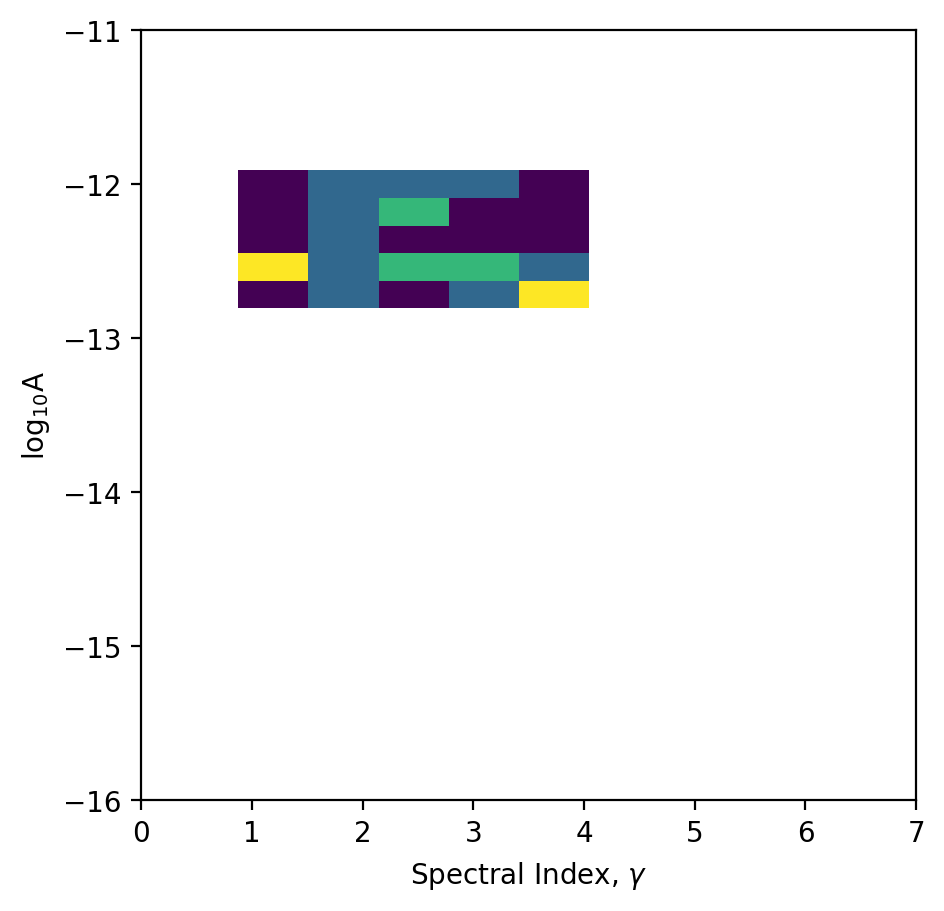

In [20]:
# plot rn distribution
plt.figure(figsize=[5,5])
plt.hist2d(irns[1],irns[0], bins=5, density=True)
plt.xlim(0,7)
plt.ylim(-16,-11)
plt.xlabel("Spectral Index, $\gamma$")
plt.ylabel("log$_{10}$A")
#plt.title("Empircal Distribution of Psr Red Noise")
plt.show()

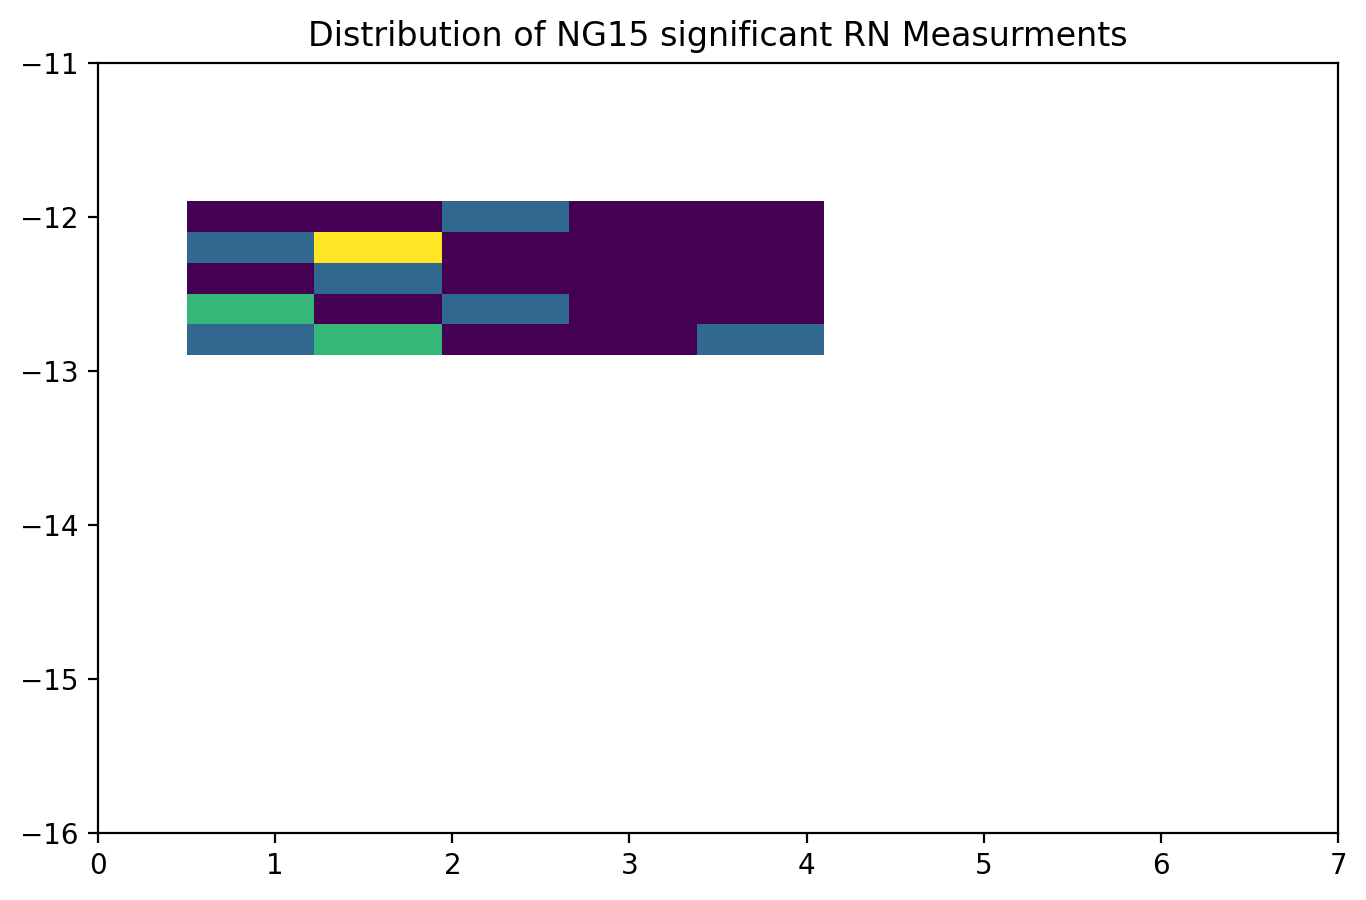

In [21]:
# compare to NG rn distribution
plt.figure(figsize=[8,5])
plt.hist2d(NG_rn['gamma_rn'][mask], NG_rn['A_rn'][mask], bins=5, density=True)
plt.xlim(0,7)
plt.ylim(-16,-11)
plt.title("Distribution of NG15 significant RN Measurments")
plt.show()

In [22]:
# set the rest to be really small
[irns[0].append(-20.) for i in range(Npsr - n_irn)]
[irns[1].append(1.5) for i in range(Npsr - n_irn)]
len(irns[0]), len(irns[1])
# make sure your output is (Npsr, Npsr)

(115, 115)

In [23]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]

fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)

$$
h_{c}(f) = A_{\rm yr}\left(\dfrac{f}{f_{\rm yr}}\right)^{-2/3}.
$$

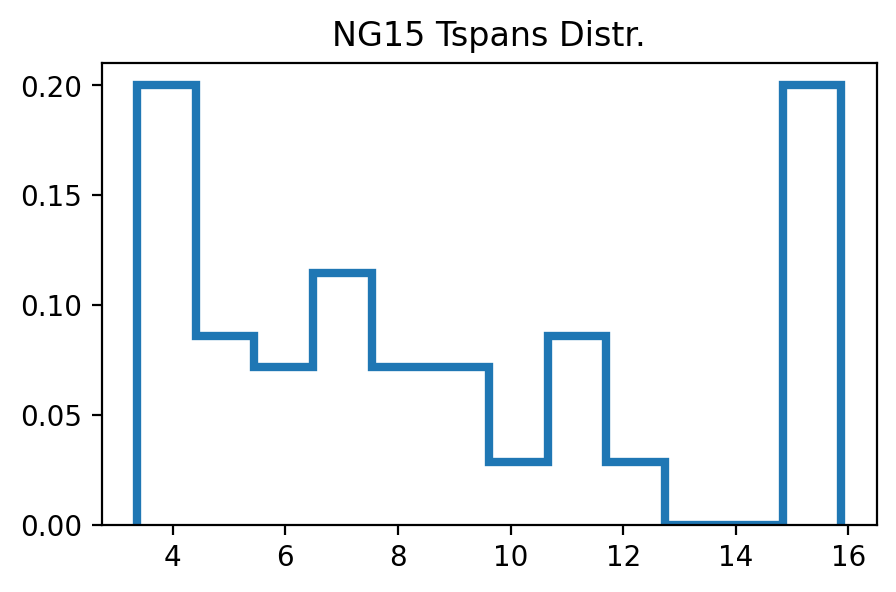

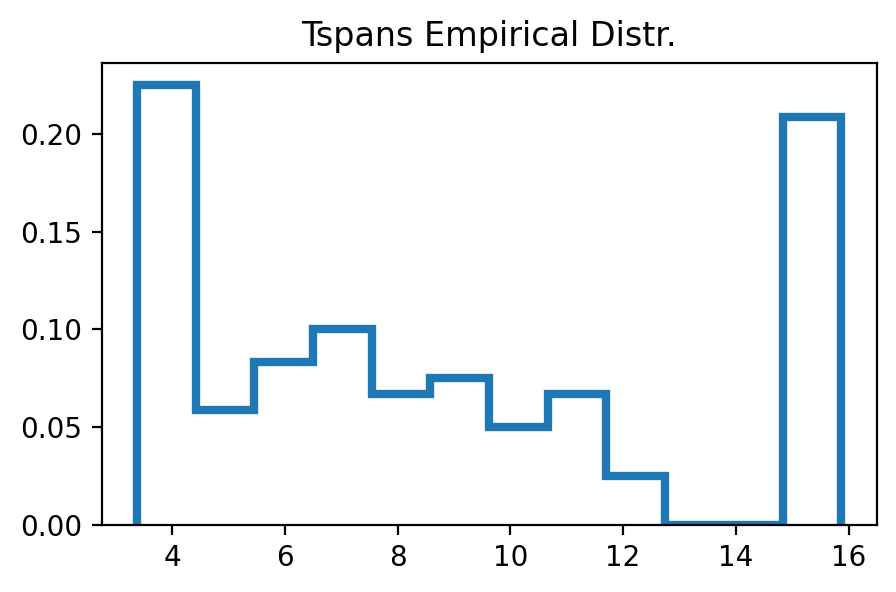

In [24]:
# get NG15 tspans
NG15_tspans = np.array([tspans[key] for key in list(tspans.keys())])
# make empirical distribution
NG15_tspans_hist = np.histogram(NG15_tspans, bins=15, density=True)
NG15_tspans_rv = sps.rv_histogram(NG15_tspans_hist)
# draw from distribution
Tspans = NG15_tspans_rv.rvs(size=Npsr)
plt.figure(figsize=[5,3])
plt.hist(NG15_tspans*fyr, density=True, histtype='step', bins=12, linewidth=3)
plt.title("NG15 Tspans Distr.")
plt.show()
plt.close()
plt.figure(figsize=[5,3])
plt.hist(Tspans*fyr, density=True, histtype='step', bins=12, linewidth=3)
plt.title("Tspans Empirical Distr.")
plt.show()

In [25]:
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)

In [26]:
psrs_sim_gpta = hsim.sim_pta(timespan=Tspans*fyr, # need units to be years
                    cad=20,
                    sigma=1.45*sigmas*np.sqrt(np.pi), # the sqrt(pi) is DMX transmission function and the 1.5 is like efac or something
                    A_rn=10.**np.array(irns[0]),
                    alpha=irns[1],
                    freqs=freqs,
                    A_gwb=10.**A_gwb,
                    gamma_gwb=alpha_gwb,
                    #gamma_gwb=-2/3,
                    phi=phi_gpta,
                    theta=theta_gpta,
                    uneven=True)

In [27]:
specs_gpta = []
for p in tspan_filter(psrs_sim_gpta):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_gpta.append(sp)

In [28]:
GWBSC = hsen.GWBSensitivityCurve(spectra=specs_gpta, orf='hd', autocorr=False)
GPTA_GWB_SNR = GWBSC.SNR(S_h)
gwb_label = f"injected GWB @SNR={GPTA_GWB_SNR:.3f}"
print(f"GPTA GWB SNR {GPTA_GWB_SNR:.4f}")

GPTA GWB SNR 6.8348


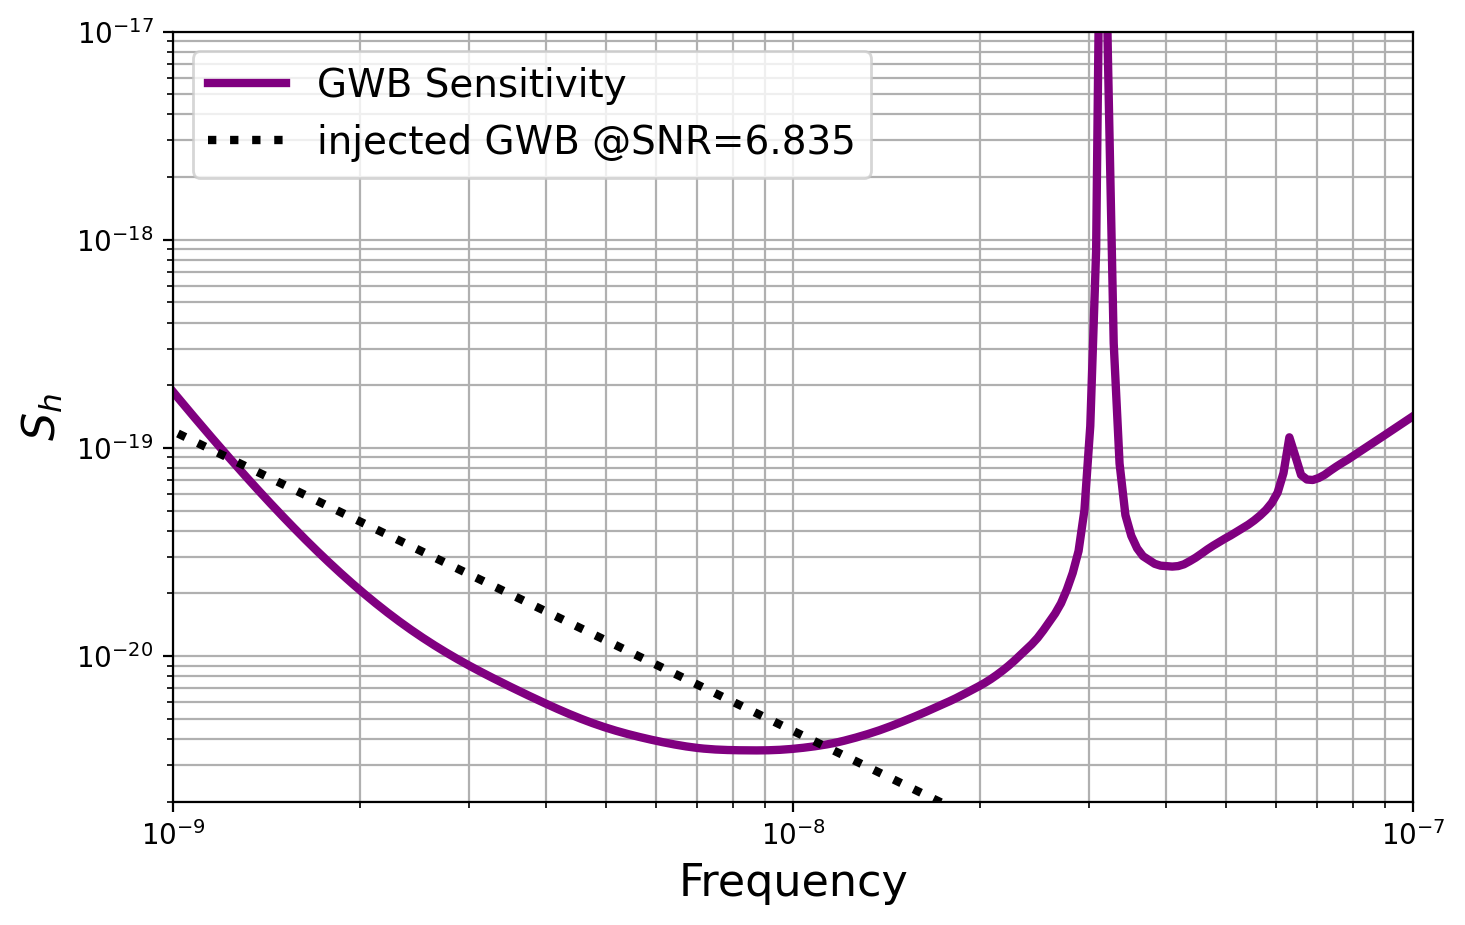

In [29]:
# Plot GWB SC
plt.figure(figsize=[8,5])
plt.loglog(GWBSC.freqs, GWBSC.S_eff,label="GWB Sensitivity", color = "Purple", linewidth= 3)
plt.loglog(GWBSC.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = gwb_label)
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('$S_h$', fontsize=16)
#plt.title('GPTA GWB Sensitvity', fontsize = 24)
plt.ylim((2e-21,1e-17))
plt.xlim((1e-9,1e-7))
plt.grid(which='both')
plt.show()

In [30]:
ng15sky_path = '/home/baierj/projects/hasasia2/extra_data/ng15yr_v1p1_pint_logf_m2a_red_noise_vg_gwb_skysc.has'
with open(ng15sky_path, 'rb') as fp:
    ng15yr_skymap = pickle.load(fp)
# with open('/Users/baierj/Documents/nanograv/big_data/ng15yr_v1p1_pint_logf_m2a_red_noise_vg_gwbsc.has', 'rb') as fp2:
#     ng15yr_GWBSC = pickle.load(fp2)

In [31]:
# # Plot GWB SC
# plt.figure(figsize=[8,5])
# plt.loglog(GWBSC.freqs, GWBSC.h_c,label="GPTA GWB Sensitivity", color = "Purple", linewidth= 3, alpha=0.75)
# plt.loglog(ng15yr_GWBSC.freqs, ng15yr_GWBSC.h_c,label="NG15yr GWB Sensivity", color = "Green", linewidth= 3, alpha=0.75)
# #plt.loglog(GWBSC.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = gwb_label)
# plt.legend(loc='upper left')
# plt.xlabel('Frequency', fontsize=16)
# plt.ylabel('h_c', fontsize=16)
# plt.title('GPTA GWB Sensitvity', fontsize = 24)
# plt.grid(which='both')
# plt.show()

In [32]:
SM_gpta = hsky.SkySensitivity(spectra=specs_gpta, theta_gw=theta_gw, phi_gw=phi_gw,)

In [33]:
# gets the indices of the best and worst sky position (at the first frequency)
idx_of_worst_sky_position = np.argmax(SM_gpta.S_effSky[0])
idx_of_best_sky_position = np.argmin(SM_gpta.S_effSky[0])

def sky_ave_detect(sm,snr=3):
    snr /= 2
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/sm.Tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work

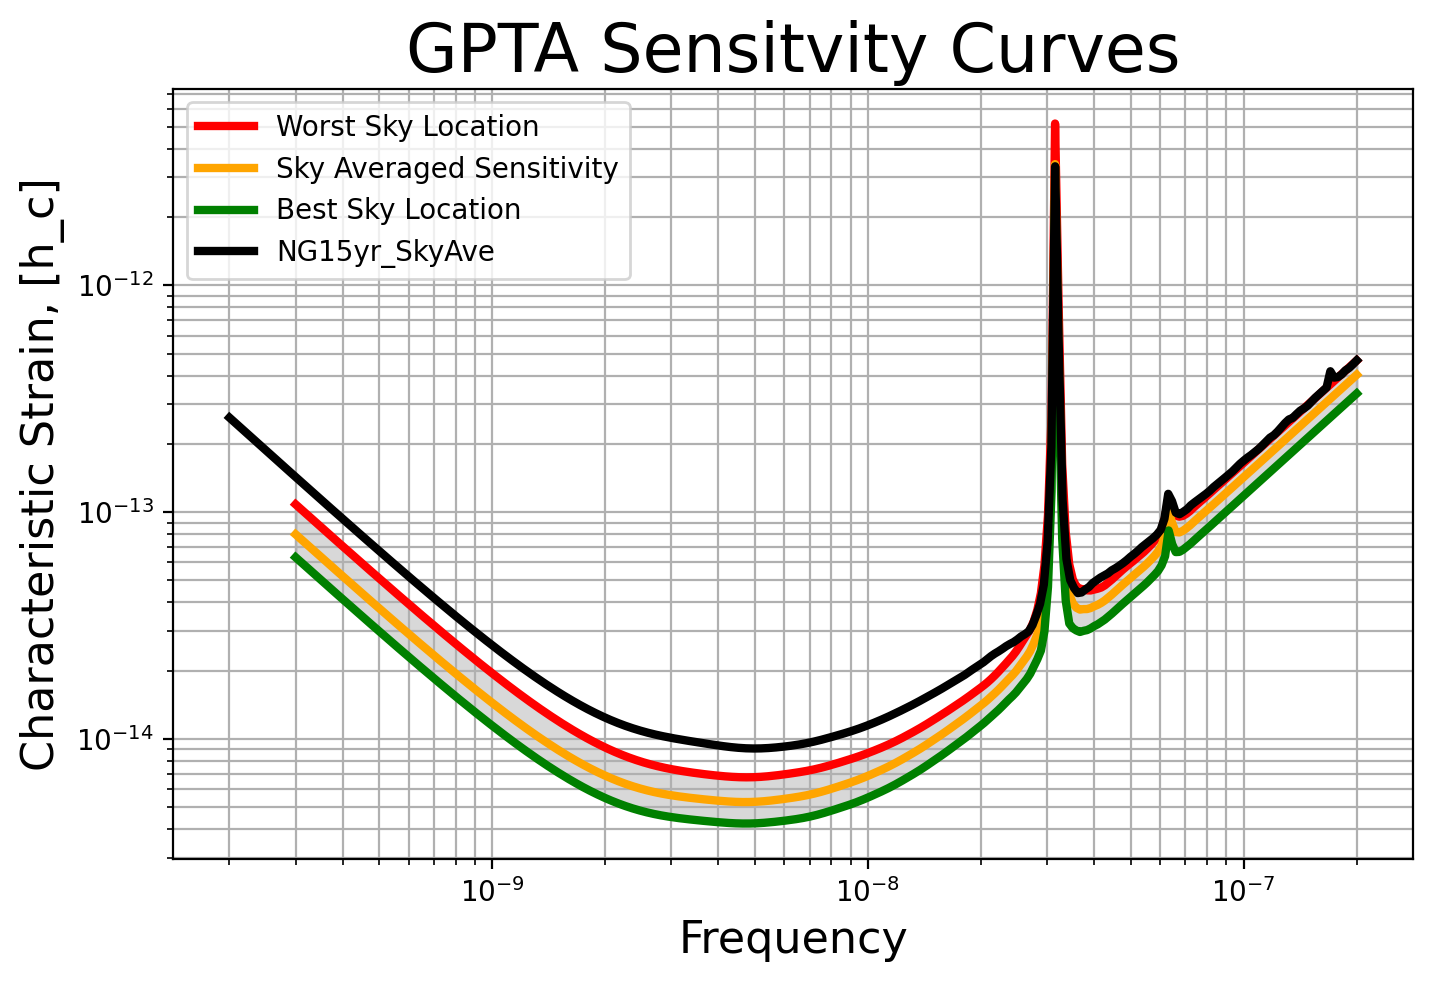

In [34]:
#Compare the sensitivity curves visually
plt.figure(figsize=[8,5])
# plt.loglog(SM_gpta.freqs, SM_gpta.S_eff,
#            label='GPTA Data',lw=2, color="Purple")
plt.loglog(SM_gpta.freqs, 2*SM_gpta.h_c[:,idx_of_worst_sky_position],label="Worst Sky Location", color = "Red", linewidth= 3)
plt.loglog(SM_gpta.freqs, 2*np.mean(SM_gpta.h_c, axis=1), label = "Sky Averaged Sensitivity", color="Orange", linewidth=3)
plt.loglog(SM_gpta.freqs, 2*SM_gpta.h_c[:,idx_of_best_sky_position],label="Best Sky Location", color="Green", linewidth=3)
plt.loglog(ng15yr_skymap.freqs, 2*np.mean(ng15yr_skymap.h_c, axis=1),label="NG15yr_SkyAve", color="Black", linewidth=3)
plt.fill_between(SM_gpta.freqs,2*SM_gpta.h_c[:,idx_of_worst_sky_position],2*SM_gpta.h_c[:,idx_of_best_sky_position], color ="Grey", alpha=0.3 )
#plt.loglog(SM_gpta.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "GWB @SNR=3??")
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Characteristic Strain, [h_c]', fontsize=16)
plt.title('GPTA Sensitvity Curves', fontsize = 24)
plt.grid(which='both')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


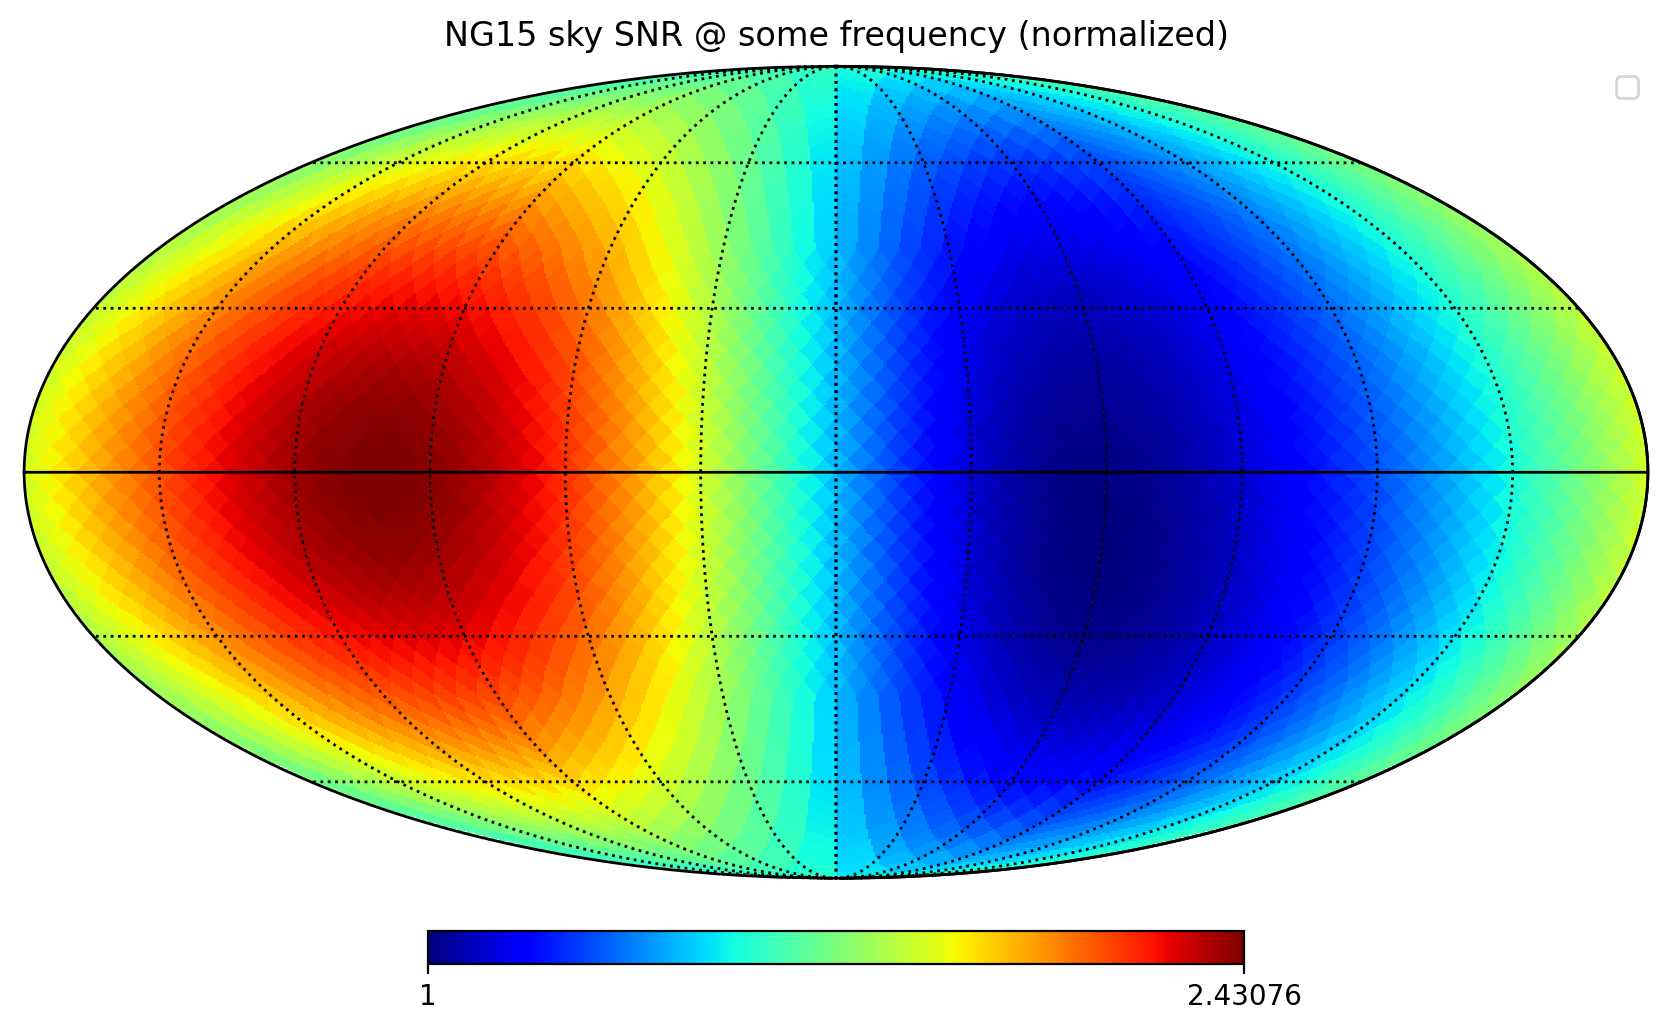

In [35]:
# visualize sources and pulsars
hp.mollview(0.5*ng15yr_skymap.SNR(4.158e-13)[0]/min(0.5*ng15yr_skymap.SNR(4.158e-13)[0]), rot = (180,0,0),
            cmap='jet',cbar=True,title='')
fig = plt.gcf()
ax = plt.gca()
hp.graticule()
# hp.visufunc.projscatter(theta_gpta,phi_gpta,marker='*',
#                         color='red',edgecolors='k',s=150, label="GPTA Pulsar")
# hp.visufunc.projscatter([theta_gpta[i] for i in np.concatenate(nearest_idxs) ], 
#                         [phi_gpta[i] for i in np.concatenate(nearest_idxs) ], marker='*',
#                         color='Orange',edgecolors='k',s=300, label = "Nearest 5 psr")
# hp.visufunc.projscatter(source_thetas, source_phis, marker='.',
#                         color='pink',edgecolors='k',s=350, label = "Test Source")
plt.legend()
plt.title('NG15 sky SNR @ some frequency (normalized)')
#plt.savefig(f'{fig_dir}/psrs_test_srcs_sensitivity.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

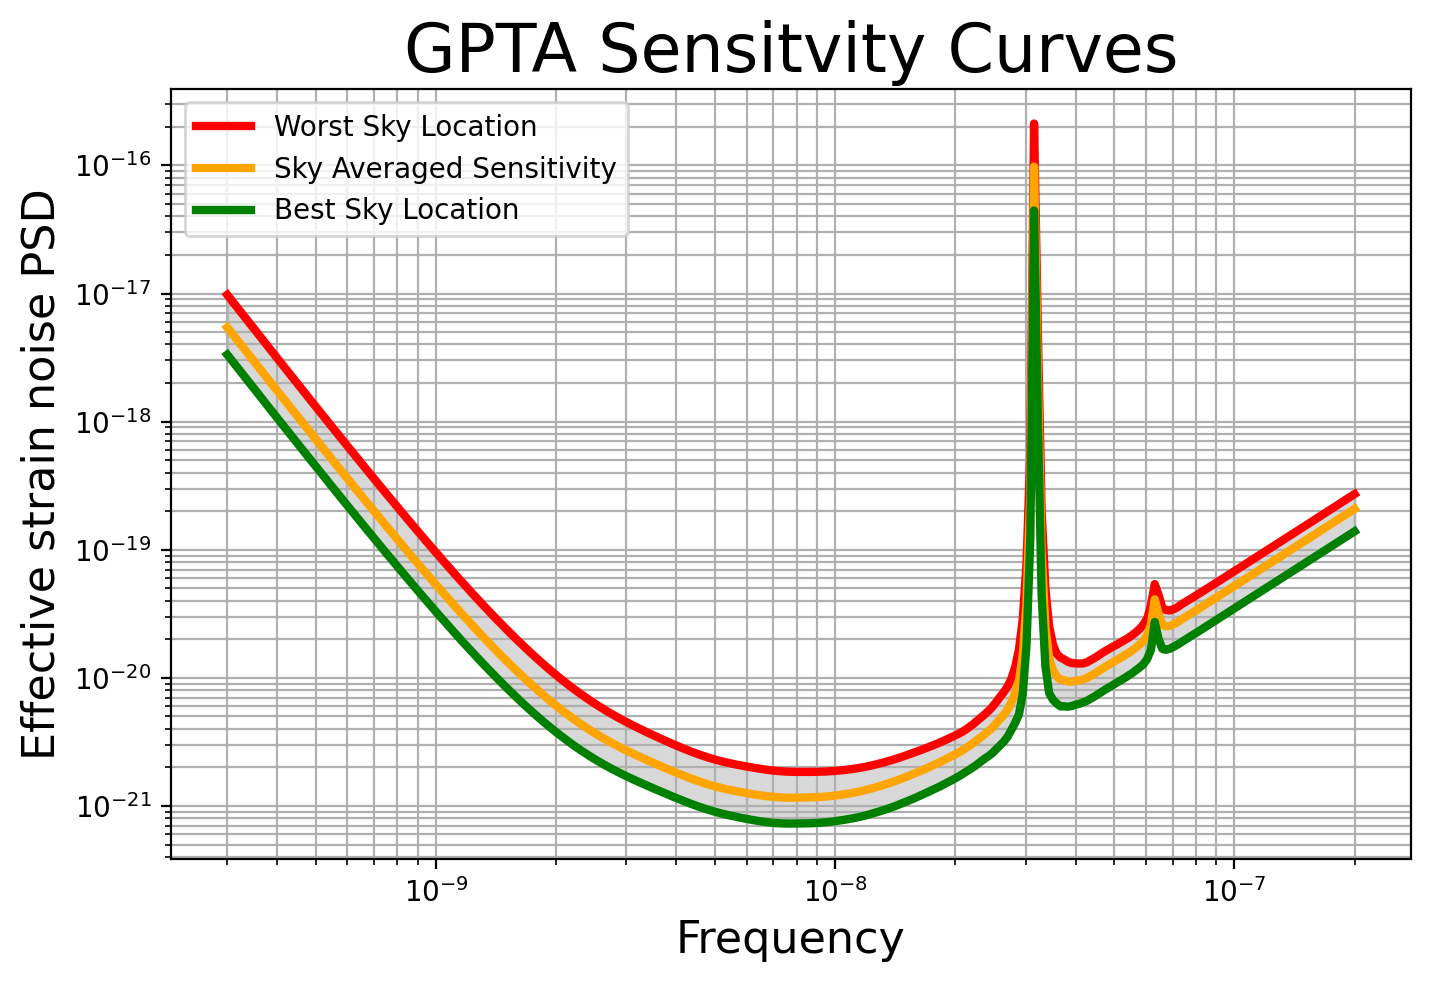

In [36]:
#Compare the sensitivity curves visually
plt.figure(figsize=[8,5])
# plt.loglog(SM_gpta.freqs, SM_gpta.S_eff,
#            label='GPTA Data',lw=2, color="Purple")
plt.loglog(SM_gpta.freqs, SM_gpta.S_eff[:,idx_of_worst_sky_position],label="Worst Sky Location", color = "Red", linewidth= 3)
plt.loglog(SM_gpta.freqs, np.mean(SM_gpta.S_eff, axis=1), label = "Sky Averaged Sensitivity", color="Orange", linewidth=3)
plt.loglog(SM_gpta.freqs, SM_gpta.S_eff[:,idx_of_best_sky_position],label="Best Sky Location", color="Green", linewidth=3)
plt.fill_between(SM_gpta.freqs,SM_gpta.S_eff[:,idx_of_worst_sky_position],SM_gpta.S_eff[:,idx_of_best_sky_position], color ="Grey", alpha=0.3 )
#plt.loglog(SM_gpta.freqs, plaw_h, color = 'k', linewidth=3, linestyle = ":", label = "GWB @SNR=3??")
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Effective strain noise PSD', fontsize=16)
plt.title('GPTA Sensitvity Curves', fontsize = 24)
plt.grid(which='both')
plt.show()

# Next, we want to project the GPTA into the future
### we build out the array to a max tpsan of 40 years assuming...
    - we don't upgrade telescopes
    - we add 2 pulsars per year
    - we only include pulsars after 3 years of data
    - all other parameters are drawn from the built empirical distributions

In [37]:
np.random.seed(0)
more_years = 40-max(Tspans*fyr)-3 # assume we having been adding psrs since 3 years before the 15yr ended.
new_Npsr = int(more_years * 2.)
new_theta_gpta = theta_rv.rvs(size=new_Npsr)
new_phi_gpta = phi_rv.rvs(size=new_Npsr)
new_sigmas = 10**(NG15_wn_rv.rvs(size=new_Npsr)) * 10**-6
new_tspans = np.sort(np.concatenate([np.linspace(1, more_years, int(more_years)), 
                        np.linspace(1,more_years, int(more_years))]))
sig_irn_frac = 12. / 67.
new_n_irn = int(np.round(new_Npsr * sig_irn_frac))
new_irns = np.array([rn2d.draw().tolist() for i in range(new_n_irn)]).T.tolist()
[new_irns[0].append(-20.) for i in range(new_Npsr - new_n_irn)]
[new_irns[1].append(1.5) for i in range(new_Npsr - new_n_irn)]
# make sure these all match in quantity
len(new_theta_gpta), len(new_phi_gpta), len(new_sigmas), len(new_irns[0]), len(new_irns[1])

(42, 42, 42, 42, 42)

In [38]:
# append all of these values
full_theta_gpta = np.append(theta_gpta, new_theta_gpta)
full_phi_gpta = np.append(phi_gpta, new_phi_gpta)
full_sigmas = np.append(sigmas, new_sigmas)
extend_Tspans = Tspans*fyr + (40. - max(Tspans)*fyr) # converting this to years here !!
full_Tspans = np.append(extend_Tspans, new_tspans)
full_irns = np.array([np.append(irns[0], new_irns[0]),
                      np.append(irns[1], new_irns[1])])
len(full_theta_gpta), len(full_phi_gpta), len(full_sigmas), len(full_irns[0]), len(full_irns[1])


(157, 157, 157, 157, 157)

In [39]:
# make sure that tpsan is in years
print(max(full_Tspans))

40.0


In [46]:
# i made these data in the other notebook. it is the sensitivity to the background Seff_I for individual pulsars.
mkrsz = [7.82051282051282, 7.948717948717949, 7.3076923076923075, 21.153846153846153, 17.820512820512818, 24.23076923076923, 19.743589743589745, 16.538461538461537, 22.17948717948718, 22.820512820512818, 20.384615384615383, 24.487179487179485, 23.205128205128204, 23.589743589743588, 7.179487179487179, 21.92307692307692, 24.102564102564102, 6.410256410256411, 22.435897435897434, 21.025641025641026, 23.97435897435897, 7.692307692307692, 24.358974358974358, 10.64102564102564, 21.28205128205128, 22.69230769230769, 23.076923076923077, 23.846153846153843, 9.23076923076923, 23.717948717948715, 5.384615384615385, 24.74358974358974, 21.41025641025641, 5.512820512820513, 22.94871794871795, 11.153846153846153, 17.564102564102562, 13.333333333333332, 22.307692307692307, 23.333333333333332, 9.102564102564102, 6.153846153846153, 12.051282051282051, 23.46153846153846, 22.564102564102562, 25.0, 6.794871794871795, 13.717948717948717, 7.564102564102564, 20.128205128205128, 8.333333333333332, 13.58974358974359, 10.384615384615383, 20.64102564102564, 24.615384615384613, 10.0, 16.666666666666664, 20.0, 17.05128205128205, 8.461538461538462, 11.923076923076923, 21.794871794871792, 10.769230769230768, 7.051282051282051, 5.0, 6.0256410256410255, 20.51282051282051, 18.333333333333332, 9.358974358974358, 19.487179487179485, 15.897435897435896, 20.897435897435898, 13.846153846153845, 14.358974358974358, 6.538461538461538, 6.282051282051282, 5.6410256410256405, 16.025641025641026, 14.87179487179487, 5.769230769230769, 8.205128205128204, 13.46153846153846, 5.897435897435898, 9.871794871794872, 16.153846153846153, 18.076923076923077, 19.615384615384613, 10.128205128205128, 7.435897435897436, 12.82051282051282, 6.666666666666666, 13.205128205128204, 19.87179487179487, 5.128205128205128, 11.410256410256409, 15.128205128205128, 16.28205128205128, 10.897435897435898, 18.589743589743588, 11.794871794871794, 15.769230769230768, 20.769230769230766, 18.205128205128204, 9.615384615384615, 11.538461538461538, 22.05128205128205, 12.692307692307692, 13.974358974358974, 17.307692307692307, 17.17948717948718, 10.512820512820513, 18.97435897435897, 19.102564102564102, 11.025641025641026, 6.923076923076923, 12.435897435897434, 18.717948717948715, 17.435897435897434, 12.179487179487179, 14.102564102564102, 8.717948717948717, 8.846153846153847, 20.256410256410255, 14.23076923076923, 19.23076923076923, 12.564102564102564, 17.692307692307693, 21.666666666666664, 5.256410256410256, 12.307692307692307, 15.512820512820511, 10.256410256410255, 14.487179487179485, 9.743589743589743, 8.58974358974359, 21.538461538461537, 12.948717948717949, 18.46153846153846, 11.282051282051281, 16.92307692307692, 18.846153846153847, 13.076923076923077, 9.487179487179487, 19.358974358974358, 16.794871794871796, 15.64102564102564, 24.87179487179487, 16.41025641025641, 15.256410256410255, 14.743589743589743, 14.615384615384615, 8.076923076923077, 15.384615384615383, 8.974358974358974, 11.666666666666666, 15.0, 17.94871794871795]

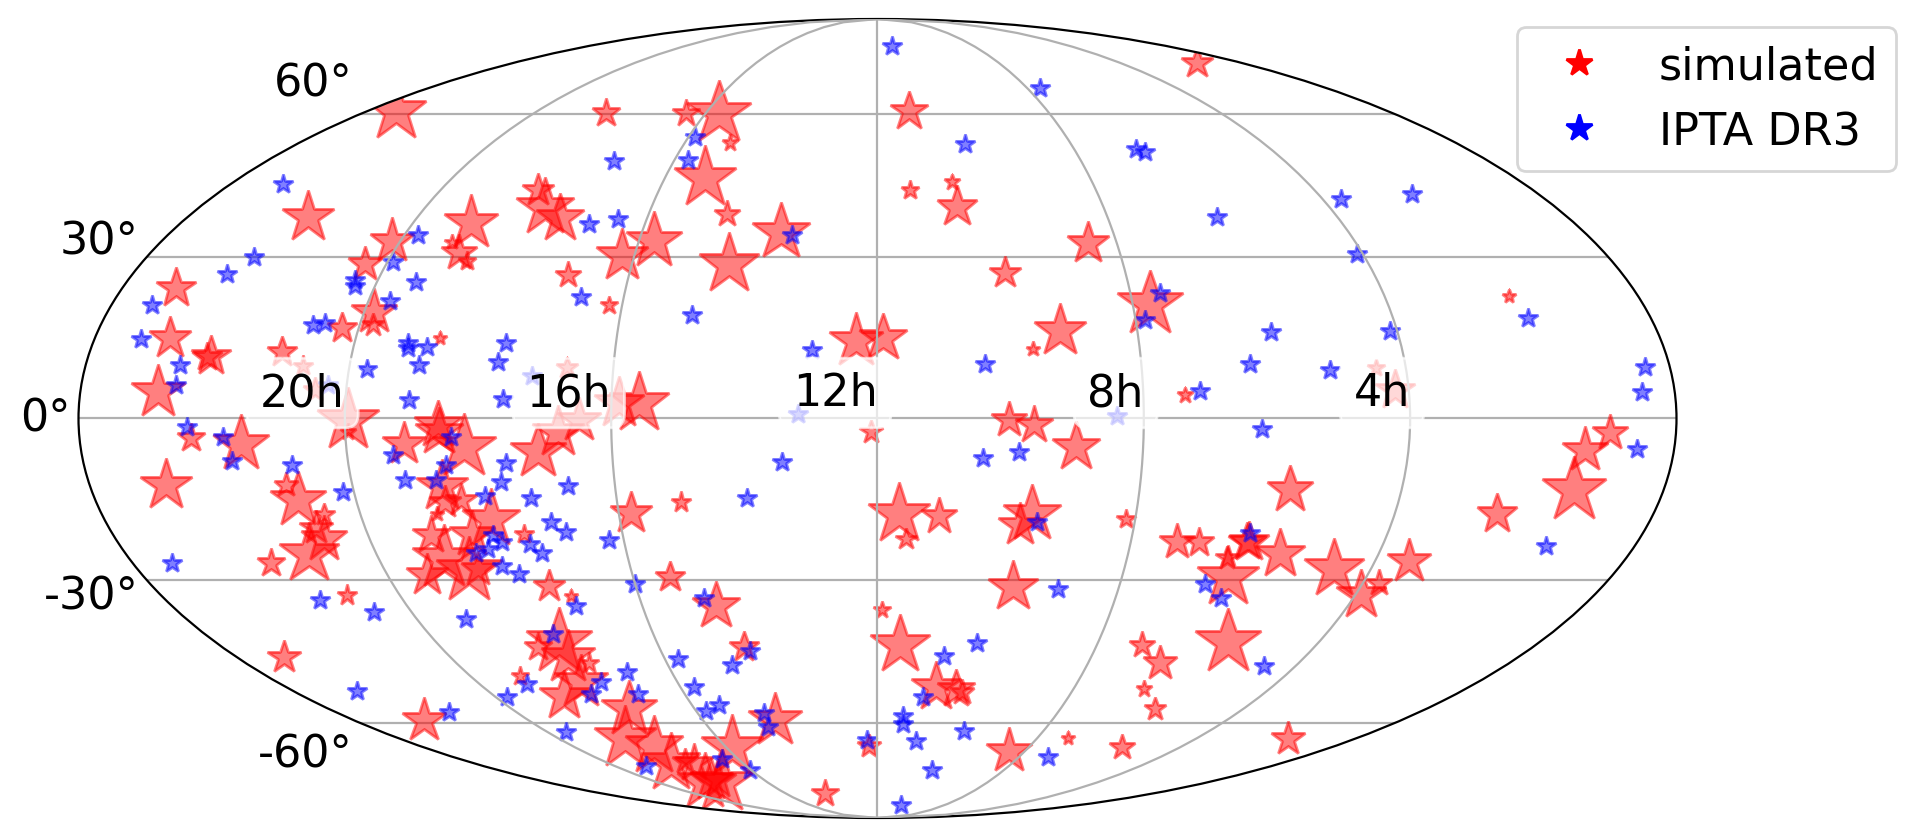

In [168]:
cmap = sns.color_palette("light:b", as_cmap=True)
wmap = mpl.colormaps['grey']
fig = hp.projview(np.zeros(NPIX), projection_type="mollweide", 
            graticule=True, graticule_labels=True, cbar=False, rot = (180,0,0), flip='astro',
            custom_xtick_labels=["20h", "16h", "12h", "8h", "4h"],
            fontsize={'ytick_label': 16},
            #xtick_label_pad = 5,
            coord=['E'], cmap=wmap, min=-1, max=0,
            )
ax = fig.axes
ax.tick_params()
xax = ax.get_xaxis()
ax.set_xticklabels(["20h", "16h", "12h", "8h", "4h"], rotation=0, fontsize=16, 
                   horizontalalignment='right',
                  bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='white'))
# ax.set_yticklabels(['$-60^\\circ$', '$-30^\\circ$', '$0^\\circ$', '$30^\\circ$', '$60^\\circ$'], rotation=0, fontsize=16, 
#                    horizontalalignment='left',label)
                  #bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='white'))
for i in range(len(full_phi_gpta)):
    hp.newprojplot(full_theta_gpta[i],full_phi_gpta[i]-np.pi, marker='*',
                        color='red', markersize=mkrsz[i], linestyle='', alpha=0.5)
hp.newprojplot(theta_ipta,np.array(phi_ipta)-np.pi,marker='*',
                        color='blue', markersize=7.5, linestyle='', alpha=0.5)
# for i in range(2,24,2):
#     text = hp.projtext( i*180/12+3, 4,  str(i)+'h', lonlat=True, coord='G', fontsize = 'large', fontweight = 100, zorder = 10)
#     print(text)
#     text.set_path_effects([mpl.patheffects.withStroke(linewidth=4, foreground='w')])
xax.set_zorder(1000)
hp.graticule()
# fig = plt.gcf()
# ax = plt.gca()
legs = [mpl.lines.Line2D([0], [0], color='red', linestyle='', marker='*', markersize=10),
        mpl.lines.Line2D([0], [0], color='blue', linestyle='', marker='*', markersize=10)]
plt.legend(legs,['simulated', 'IPTA DR3'], fontsize=16, loc=(0.9, 0.81))
plt.savefig(f'{fig_dir}/gpta_sky_locs.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [142]:
ax.set_yticklabels?

Signature: ax.set_yticklabels(labels, *, minor=False, fontdict=None, **kwargs)
Docstring:
[*Discouraged*] Set the yaxis' tick labels with list of string labels.

.. admonition:: Discouraged

    The use of this method is discouraged, because of the dependency on
    tick positions. In most cases, you'll want to use
    ``Axes.set_[x/y/z]ticks(positions, labels)`` or ``Axes.set_yticks``
    instead.

    If you are using this method, you should always fix the tick
    positions before, e.g. by using `.Axes.set_yticks` or by explicitly
    setting a `~.ticker.FixedLocator`. Otherwise, ticks are free to
    move and the labels may end up in unexpected positions.

Parameters
----------
labels : sequence of str or of `.Text`\s
    Texts for labeling each tick location in the sequence set by
    `.Axes.set_yticks`; the number of labels must match the number of
    locations.

minor : bool
    If True, set minor ticks instead of major ticks.

fontdict : dict, optional

    .. admonition:: Dis

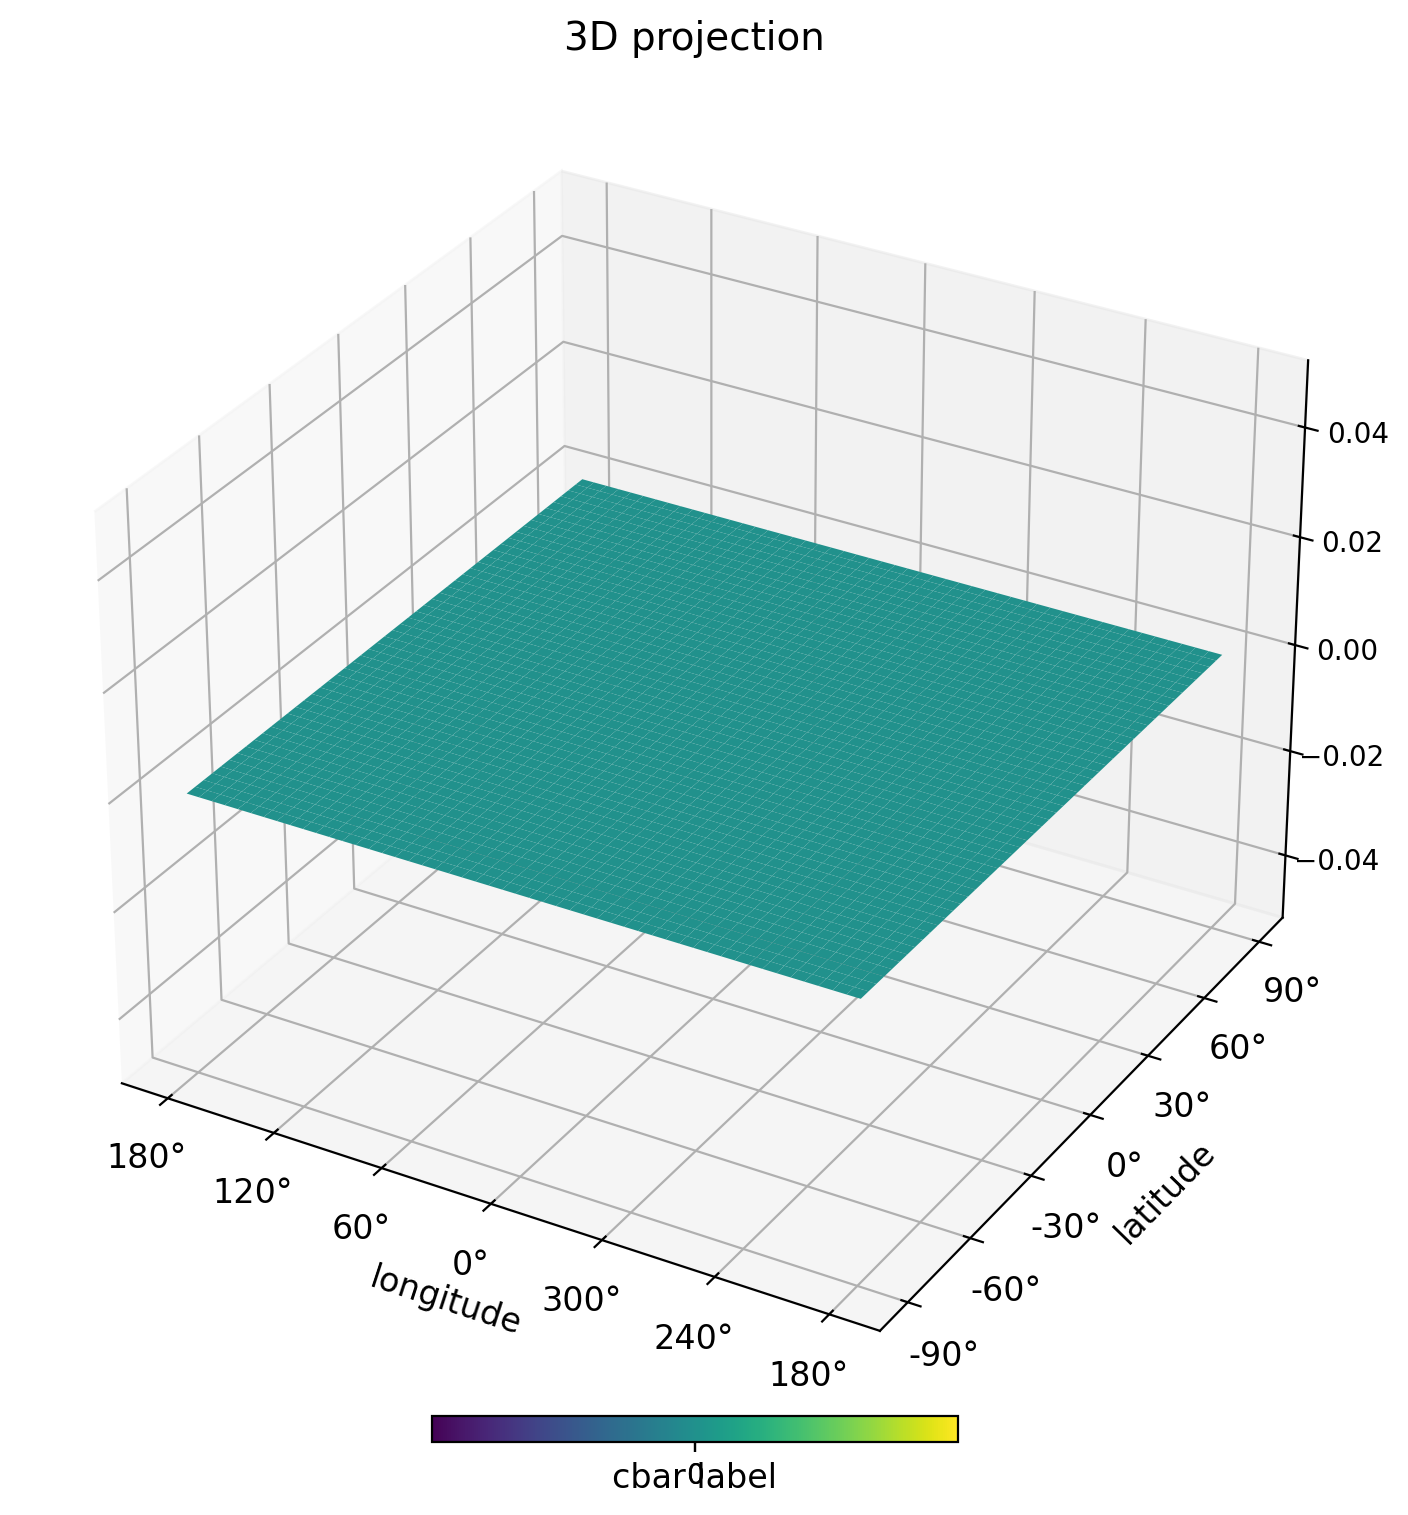

In [52]:
hp.projview(
    np.zeros(NPIX),
    coord=["G"],
    hold=False,
    graticule=True,
    graticule_labels=True,
    unit="cbar label",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    projection_type="3d",
    title="3D projection",
)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=[5,3])
plt.hist(np.log10(full_sigmas[:(-1*new_Npsr)]/10**-6), histtype='step', density=True, linewidth=3, bins=25, label="GPTA 2024")
plt.hist(np.log10(full_sigmas[(-1*new_Npsr):]/10**-6), histtype='step', density=True, linewidth=3, bins=25, label="GPTA Extended")
plt.xlabel("sigma * 10^ -6 [mus]")
plt.title("Simulated psr White Noise")
plt.legend()
plt.show()

In [ ]:
np.sort(1.13*full_sigmas*np.sqrt(np.pi))

In [ ]:
plt.figure(figsize=[5,3])
irns_mask = full_irns[0] != -20.
plt.hist2d(full_irns[1][irns_mask], full_irns[0][irns_mask], bins=5, density=True)
plt.xlim(0,7)
plt.ylim(-16,-11)
plt.title("Empircal Distribution of Psr Red Noise")
plt.show()

In [ ]:
# name the pulsars :)
names = []
_ = [names.append(utils.skycoord_to_Jname(utils.theta_phi_to_SkyCoord(phi=this_phi, theta=this_theta))) for this_phi, this_theta in zip(full_phi_gpta, full_theta_gpta)]

In [ ]:
psrs_sim_gpta_full = hsim.sim_pta(timespan=full_Tspans, # need units to be years
                    psr_names=names,
                    cad=20,
                    sigma=1.45*full_sigmas*np.sqrt(np.pi),#*np.sqrt(np.pi), # the sqrt(pi) is DMX transmission function and the 1.13 is like efac or something
                    A_rn=10.**np.array(full_irns[0]),
                    alpha=full_irns[1],
                    freqs=freqs,
                    A_gwb=10.**A_gwb,
                    #gamma_gwb=-2/3,
                    gamma_gwb=alpha_gwb,
                    phi=full_phi_gpta,
                    theta=full_theta_gpta,
                    uneven=True)

In [ ]:
alpha_gwb

In [ ]:
np.array(full_irns[1])[5]

In [ ]:
full_specs_gpta = []
for p in tspan_filter(psrs_sim_gpta_full):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    full_specs_gpta.append(sp)

In [ ]:
full_GWBSC = hsen.GWBSensitivityCurve(spectra=full_specs_gpta, orf='hd', autocorr=False)
full_GPTA_GWB_SNR = full_GWBSC.SNR(S_h)
gwb_label = f"injected GWB has SNR={full_GPTA_GWB_SNR:.3f}"
print(f"GPTA GWB SNR {full_GPTA_GWB_SNR:.4f}")

In [ ]:
# Plot GWB SC
plt.figure(figsize=[8,5])
plt.loglog(full_GWBSC.freqs, full_GWBSC.S_eff,label="GWB Sensivity", color = "Purple", linewidth= 3)
plt.loglog(full_GWBSC.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = gwb_label)
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('S_h', fontsize=16)
plt.title('GPTA GWB Sensitvity', fontsize = 24)
plt.grid(which='both')
plt.ylim(bottom=1e-21)
plt.show()

In [ ]:
#Compare the sensitivity curves visually
SM_gpta = hsky.SkySensitivity(spectra=full_specs_gpta, theta_gw=theta_gw, phi_gw=phi_gw)
# gets the indices of the best and worst sky position (at the first frequency)
idx_of_worst_sky_position = np.argmax(SM_gpta.S_effSky[0])
idx_of_best_sky_position = np.argmin(SM_gpta.S_effSky[0])
def sky_ave_detect(sm,snr=3):
    snr /= 2
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/sm.Tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work
plt.figure(figsize=[8,5])
# plt.loglog(SM_gpta.freqs, SM_gpta.S_eff,
#            label='GPTA Data',lw=2, color="Purple")
plt.loglog(SM_gpta.freqs, 2*SM_gpta.h_c[:,idx_of_worst_sky_position],label="Worst Sky Location", color = "Red", linewidth= 3)
plt.loglog(SM_gpta.freqs, 2*np.mean(SM_gpta.h_c, axis=1), label = "Sky Averaged Sensitivity", color="Orange", linewidth=3)
plt.loglog(SM_gpta.freqs, 2*SM_gpta.h_c[:,idx_of_best_sky_position],label="Best Sky Location", color="Green", linewidth=3)
plt.loglog(ng15yr_skymap.freqs, 2*np.mean(ng15yr_skymap.h_c, axis=1),label="NG15yr_SkyAve", color="Black", linewidth=3)
plt.fill_between(SM_gpta.freqs,2*SM_gpta.h_c[:,idx_of_worst_sky_position],2*SM_gpta.h_c[:,idx_of_best_sky_position], color ="Grey", alpha=0.3 )
#plt.loglog(SM_gpta.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "GWB @SNR=3??")
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Characteristic Strain, [h_c]', fontsize=16)
plt.title('GPTA Sensitvity Curves at 40 years', fontsize = 24)
plt.grid(which='both')
plt.show()

 ## Save the `hsen.spectra` or `hsen.Pulsars` as a .pkl

In [ ]:
# save to pickle file. the sky maps are too big for git, 
# but we can save individual spectra or pulsars.
# SM_gpta.to_pickle('./data/GenericPTA_SkyMap.pkl')
# GWBSC.to_pickle('./data/GenericPTA_GWB.pkl')
# for i, psr in enumerate(psrs_sim_gpta_full):
#     with open(f'./data/gpta_psrs_40yrs/gpta_psr_{i}.pkl', 'wb') as fout:
#         pickle.dump(psr, fout, fix_imports=True)
# for i, psr in enumerate(psrs_sim_gpta_full):
#     with open(f'./data/gpta_psrs_alpha_neg_23/gpta_psr_gwb_alpha_negative_two_thirds_{i}.pkl', 'wb') as fout:
#         pickle.dump(psr, fout, fix_imports=True)

In [ ]:
# # trying to check my numbers so i am remaking pulsars
# for i, psr in enumerate(psrs_sim_gpta_full):
#     with open(f'./data/gpta_psrs_40yrs_v2/gpta_psr_{i}_v2.pkl', 'wb') as fout:
#         pickle.dump(psr, fout, fix_imports=True)